In [40]:
len(set(i for i in os.listdir('../../NRRD Files/') if i.endswith('CT.nrrd')))

104

In [18]:
[i.split('_')[1] for i in os.listdir('../data/Fused 2/') if i.endswith('.jpg')]

['230',
 '225',
 '240',
 '101',
 '141',
 '237',
 '57',
 '219',
 '113',
 '14',
 '334',
 '171',
 '61',
 '211',
 '41',
 '47',
 '11',
 '152',
 '63',
 '59',
 '131',
 '70',
 '482',
 '290',
 '510',
 '226',
 '297',
 '40',
 '154',
 '219',
 '206',
 '87',
 '355',
 '19',
 '241',
 '122',
 '163',
 '86',
 '115',
 '49',
 '52',
 '320',
 '268',
 '43',
 '276',
 '193',
 '232',
 '28',
 '86',
 '231',
 '225',
 '390',
 '202',
 '2',
 '1',
 '141',
 '147',
 '105',
 '41',
 '67',
 '140',
 '81',
 '46',
 '103',
 '91',
 '32',
 '182',
 '139',
 '167',
 '143',
 '130',
 '284',
 '97',
 '137',
 '62',
 '53',
 '105',
 '227',
 '401',
 '51',
 '214',
 '244',
 '198',
 '65',
 '45',
 '52',
 '148',
 '13',
 '14',
 '185',
 '90',
 '396',
 '147',
 '71',
 '188',
 '208',
 '101',
 '82',
 '12',
 '211',
 '5',
 '156',
 '35',
 '24',
 '91',
 '226',
 '137',
 '232',
 '190',
 '3',
 '234',
 '117',
 '368',
 '75',
 '184',
 '15',
 '239',
 '54',
 '234',
 '166',
 '333',
 '220',
 '54',
 '170',
 '283',
 '4',
 '236',
 '246',
 '455',
 '130',
 '269',
 '255'

In [70]:
from monai.transforms import LoadImage, Spacing, NormalizeIntensity, Compose, Resize
import matplotlib.pyplot as plt
import numpy as np
import nrrd
import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import concurrent.futures
import monai

file_path = '/home/hamad/pttut/NRRD Files/R01-005_CT.nrrd'
clinical_path = '/home/hamad/pttut/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv'
clinical_df = pd.read_csv(clinical_path, index_col=0)
patients_to_remove = ['R01-027', 'R01-029', 'R01-031', 'R01-163']
clinical_df = clinical_df.drop(patients_to_remove, axis=0)

train_df = '/home/hamad/pttut/project/data/csvs/train_data_resamples.csv'
test_df = '/home/hamad/pttut/project/data/csvs/test_data_resamples.csv'

train_df = pd.read_csv(train_df, index_col=-1)

# split train_df into train and val

train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Histology'])


test_df = pd.read_csv(test_df, index_col=-1)

#print(train_df['Histology'].value_counts())

class ChestDataset(Dataset):
    def __init__(self, clinical_data, fused=False):
        self.clinical_data = clinical_data
        self.dir_to_search = ['/home/hamad/pttut/NRRD Files/', '/home/hamad/pttut/Class 1/', '/home/hamad/pttut/project/data/Fused 2/']
        self.nrrd_files = [ct for ct in os.listdir(self.dir_to_search[0]) if (ct.endswith('CT.nrrd') and ct.split('_')[0] in self.clinical_data.index)]
        self.lung_files = [ct for ct in os.listdir(self.dir_to_search[1]) if ct.split('.')[0] in self.clinical_data.index]
        self.targets = [self.clinical_data.loc[ct.split('_')[0]]['Histology'] for ct in self.nrrd_files] + [self.clinical_data.loc[ct.split('.')[0]]['Histology'] for ct in self.lung_files]
        self.unique_cases = set([ct.split('_')[0] for ct in self.nrrd_files]).union( set([ct.split('.')[0] for ct in self.lung_files]) )
        self.nrrd_files += self.lung_files
        self.fused = fused
        
        self.transforms = Compose([ 
            NormalizeIntensity(nonzero=True, channel_wise=True),
            Resize((128, 128, 128))
        ])
                                
        
    def __len__(self):
        return len(self.nrrd_files)
    
    def space_ct_scan(self, image):
        original_spacing = image.GetSpacing()
        original_size = image.GetSize()
        new_spacing = (original_spacing[0], original_spacing[1], (original_spacing[2]*original_size[2])/128.0)
        new_size = (original_size[0], original_size[1], 128)
        resampled_image = sitk.Resample(image, new_size, sitk.Transform(), sitk.sitkLinear, image.GetOrigin(), new_spacing, image.GetDirection())
        image_array = sitk.GetArrayFromImage(resampled_image)
        return image_array

    def load_file(self, file_path):
        image = sitk.ReadImage(file_path)
        image_array = self.space_ct_scan(image)
        return image_array
    
    def load_fused_images(self, patient_id):
        # we need to read a sequence of paths of the same patient
        # then we need to sort them by order
        # then we need to process each image and stack them together
        # space them to 128 slices
        image_files = [i for i in os.listdir(self.dir_to_search[2]) if i.startswith(patient_id)]
        
        # sort the files by order
        image_files.sort(key=lambda x: int(x.split('_')[1]))
        
        # load each image and stack them together
        image_arrays = []
        
        for image_file in image_files:
            image_array = plt.imread(os.path.join(self.dir_to_search[2], image_file))
            image_arrays.append(image_array)
            
        image_arrays = np.stack(image_arrays, axis=0)
        # read them as sitk images
        image_arrays = sitk.GetImageFromArray(image_arrays)
        image_array = self.space_ct_scan(image_arrays)
        return image_array
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        ct_file = self.nrrd_files[idx]
        if not 'LUNG' in ct_file:
            if self.fused:
                # search in another directory
                # sample name: id_CT.nrrd
                nrrd_dir = self.dir_to_search[2]
                # remove the _CT.nrrd from the file name
                patient_id = ct_file.split('_')[0]
                ct_array = self.load_fused_images(patient_id)
            else:
                nrrd_dir = self.dir_to_search[0] 
                ct_file_path = os.path.join(nrrd_dir, ct_file)
                ct_array = self.load_file(ct_file_path)
            
        
        else:
            nrrd_dir = self.dir_to_search[1]
            ct_file_path = os.path.join(nrrd_dir, ct_file)
            ct_array = self.load_file(ct_file_path)
            
        
        ct_array = ct_array.astype(np.float32)
        #ct_array = ct_array / 255.0
        ct_array = np.expand_dims(ct_array, axis=0)
        
        ct_tensor = torch.from_numpy(ct_array)
        
        ct_tensor = self.transforms(ct_tensor)
        
        target = self.targets[idx]
        # if target == 'Adenocarcinoma':
        #     target = 0
        # elif target == 'Squamous cell carcinoma':
        #     target = 1
        
        #ct_tensor = ct_tensor.permute(1, 0, 2, 3)
        return ct_tensor, torch.tensor(target, dtype=torch.long)

In [71]:
# test the above class
train_ds = ChestDataset(train_df, fused=True)
val_ds = ChestDataset(valid_df, fused=True)
test_ds = ChestDataset(test_df, fused=True)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, )
val_loader = DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=0, )
test_loader = DataLoader(test_ds, batch_size=2, shuffle=True, num_workers=0, )

torch.Size([1, 128, 128, 128])
torch.Size([])
tensor(0)


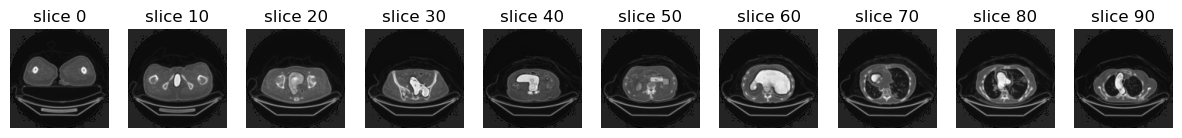

In [72]:
# load the first ct scan and plot 10 pictures every 20 frames
ct, target = train_ds[0]
print(ct.shape)
print(target.shape)
print(target)


# i need the pictures in one row using matplotlib

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 5))  # 1 row, 3 columns


for i in range(0, 100, 10):
    axes[i//10].imshow(ct[0, i, :, :], cmap='gray')
    axes[i//10].set_title('slice {}'.format(i))

for ax in axes:
    ax.axis('off')
    
plt.show()


----------
epoch 1/20
1/39, train_loss: 0.6353
2/39, train_loss: 0.6051
3/39, train_loss: 0.6047
4/39, train_loss: 0.5992
5/39, train_loss: 0.8679
6/39, train_loss: 0.7028
7/39, train_loss: 0.8418
8/39, train_loss: 0.5933
9/39, train_loss: 0.6985
10/39, train_loss: 0.5736
11/39, train_loss: 0.5135
12/39, train_loss: 0.5454
13/39, train_loss: 0.6726
14/39, train_loss: 0.8379
15/39, train_loss: 0.8374
16/39, train_loss: 0.5889
17/39, train_loss: 0.5997
18/39, train_loss: 0.8318
19/39, train_loss: 0.5855
20/39, train_loss: 0.6746
21/39, train_loss: 0.4051
22/39, train_loss: 0.8352
23/39, train_loss: 0.4850
24/39, train_loss: 0.7752
25/39, train_loss: 0.6060
26/39, train_loss: 0.6040
27/39, train_loss: 0.4916
28/39, train_loss: 0.6064
29/39, train_loss: 0.5082
30/39, train_loss: 0.6160
31/39, train_loss: 0.6965
32/39, train_loss: 0.5949
33/39, train_loss: 0.4365
34/39, train_loss: 0.6034
35/39, train_loss: 0.5161
36/39, train_loss: 0.6384
37/39, train_loss: 0.8421
38/39, train_loss: 0.5886

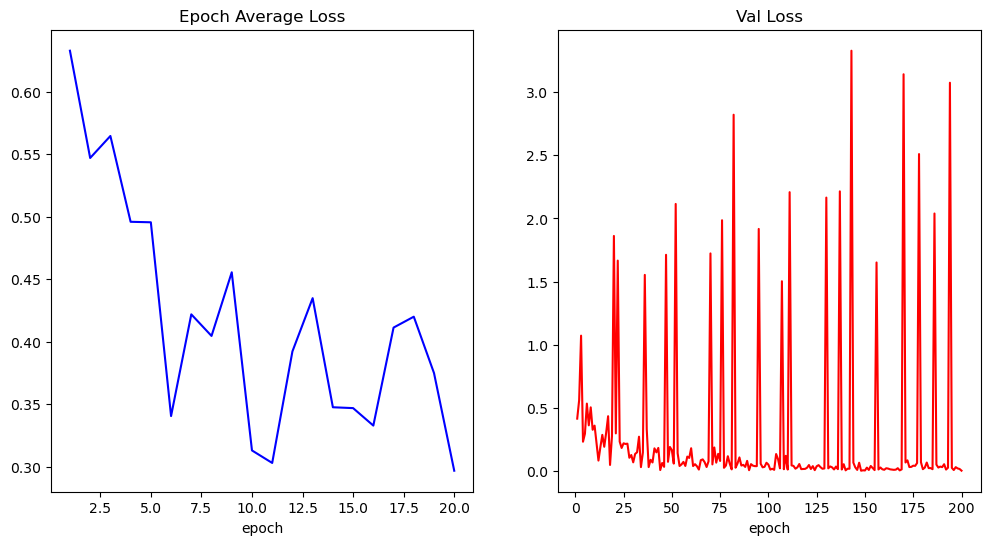

In [73]:
import torch
from monai.networks.nets import Densenet121
from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda:0')
model = Densenet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
val_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 20

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    #if (epoch + 1) % val_interval == 0:
    model.eval()

    num_correct = 0.0
    metric_count = 0
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        with torch.no_grad():
            val_outputs = model(val_images)
            value = torch.eq(val_outputs.argmax(dim=1), val_labels)
            metric_count += len(value)
            num_correct += value.sum().item()
            loss = loss_function(val_outputs, val_labels)
            val_loss_values.append(loss.item())

    metric = num_correct / metric_count
    metric_values.append(metric)

    if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
        print("saved new best metric model")

    print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
    print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
    writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()


# plot train loss vs validation loss curves

plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y, color='blue')
plt.subplot(1, 2, 2)
plt.title('Val Loss')
x = [i+1 for i in range(len(val_loss_values))]
y = val_loss_values
plt.xlabel('epoch')
plt.plot(x, y, color='red')
plt.show()








In [78]:
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=0, )
itera = iter(test_loader)
def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


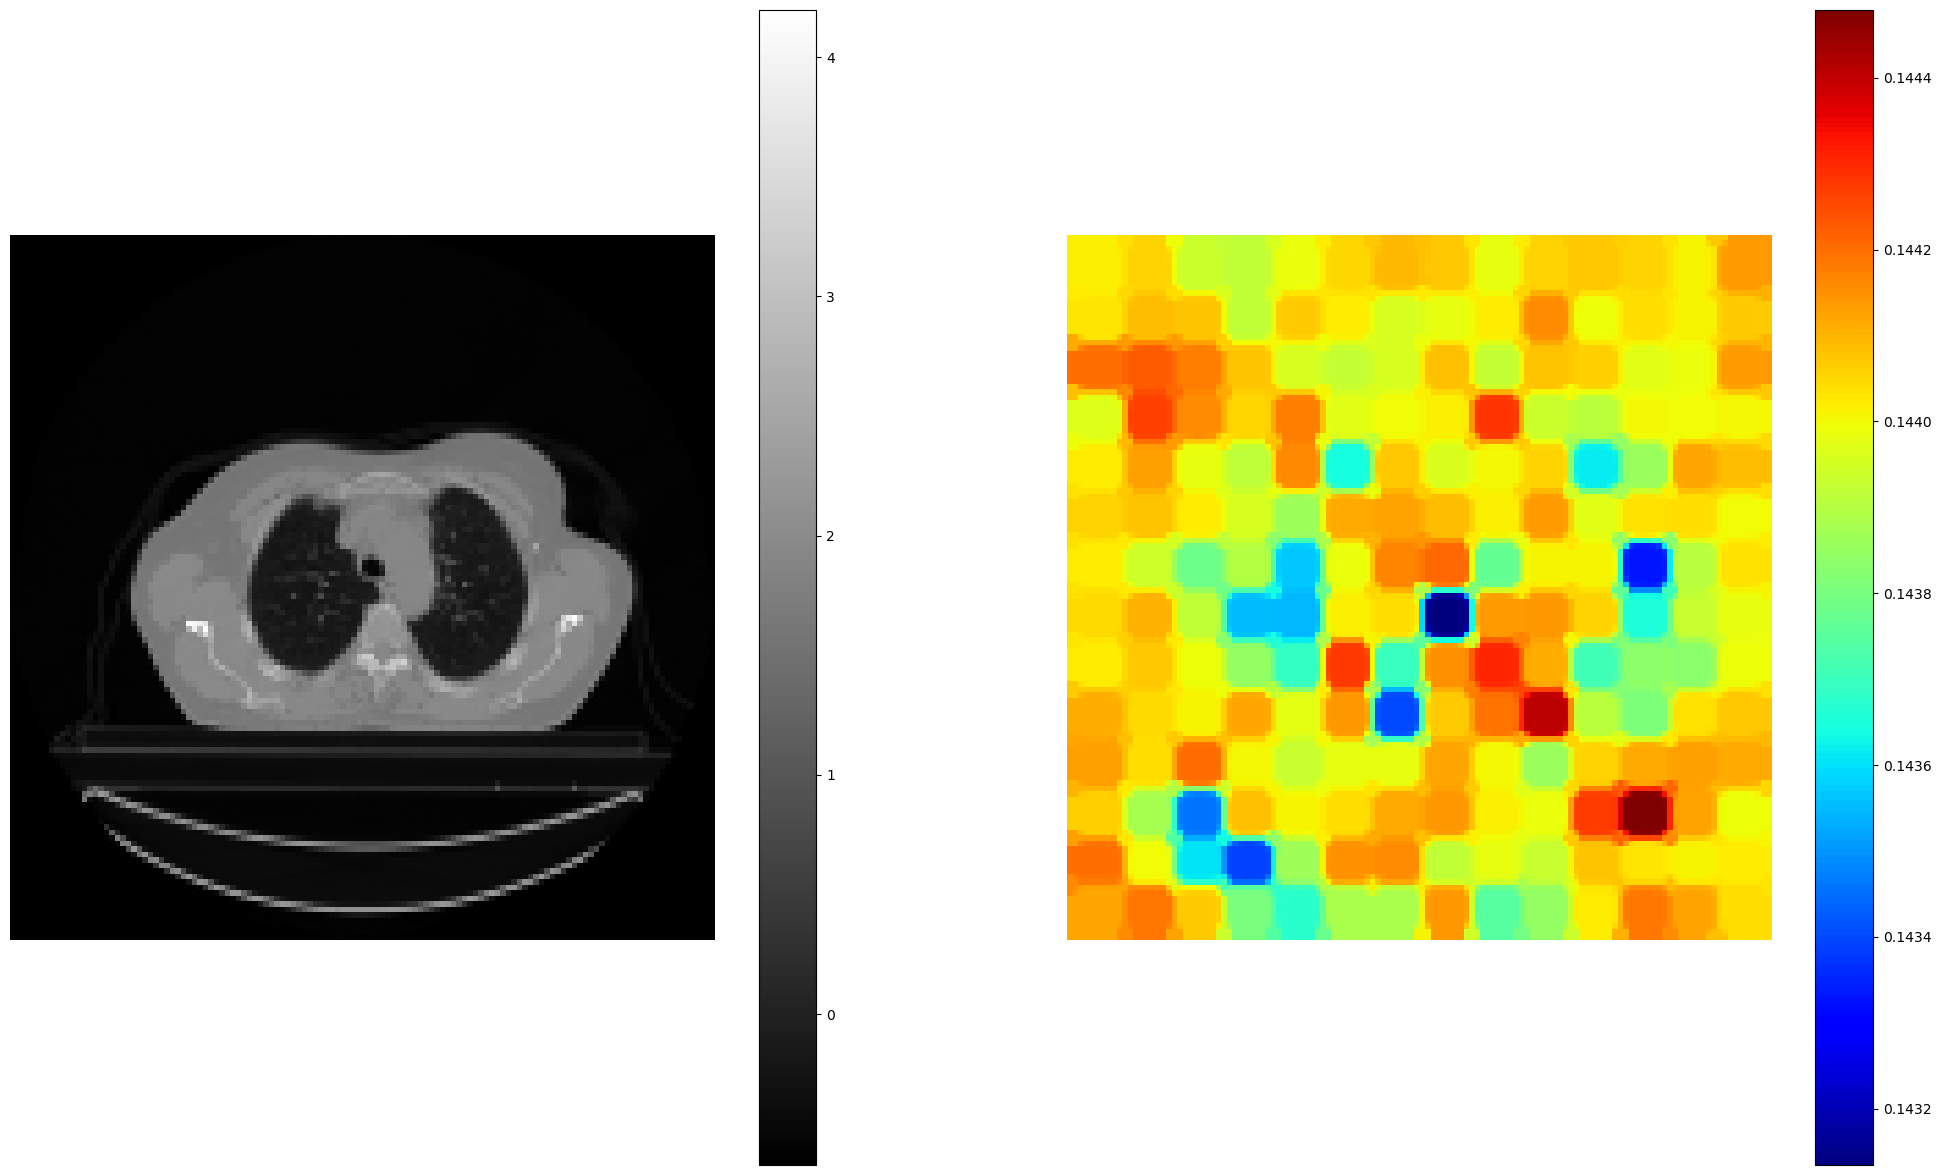

In [75]:
img, label = get_next_im()
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice =  90 #img.shape[2] // 2
occ_sens_b_box = [depth_slice - 1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[0, label.argmax().item()][None]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

In [79]:
# evaluate on the test set

model.eval()

num_correct = 0.0
metric_count = 0

y_true = []
y_pred = []


for test_data in test_loader:
    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    with torch.no_grad():
        test_outputs = model(test_images)
        value = torch.eq(test_outputs.argmax(dim=1), test_labels)
        metric_count += len(value)
        num_correct += value.sum().item()
        y_true += test_labels.tolist()
        y_pred += test_outputs.argmax(dim=1).tolist()
        
metric = num_correct / metric_count

print(f"Test accuracy: {metric:.4f} ")


Test accuracy: 0.5957 


                         precision    recall  f1-score   support

         Adenocarcinoma       0.58      1.00      0.73        26
Squamous cell carcinoma       1.00      0.10      0.17        21

               accuracy                           0.60        47
              macro avg       0.79      0.55      0.45        47
           weighted avg       0.77      0.60      0.48        47



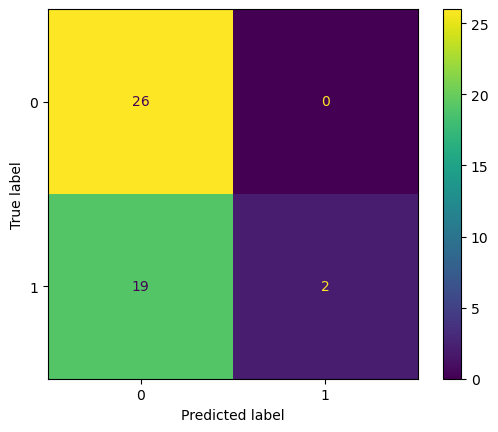

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import pandas as pd



ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()

print(classification_report(y_true, y_pred, target_names=['Adenocarcinoma', 'Squamous cell carcinoma']))
        


Val accuracy: 0.9500 
                         precision    recall  f1-score   support

         Adenocarcinoma       0.92      1.00      0.96        11
Squamous cell carcinoma       1.00      0.89      0.94         9

               accuracy                           0.95        20
              macro avg       0.96      0.94      0.95        20
           weighted avg       0.95      0.95      0.95        20



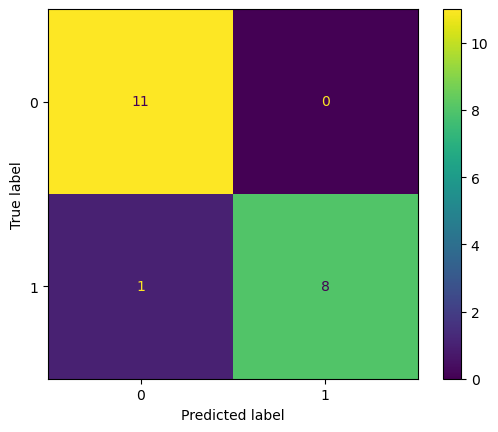

In [81]:
# evaluate on validation

model.eval()

num_correct = 0.0
metric_count = 0
y_true = []
y_pred = []
for test_data in val_loader:
    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    with torch.no_grad():
        test_outputs = model(test_images)
        value = torch.eq(test_outputs.argmax(dim=1), test_labels)
        metric_count += len(value)
        num_correct += value.sum().item()
        y_true += test_labels.tolist()
        y_pred += test_outputs.argmax(dim=1).tolist()
        
metric = num_correct / metric_count

print(f"Val accuracy: {metric:.4f} ")

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()
print(classification_report(y_true, y_pred, target_names=['Adenocarcinoma', 'Squamous cell carcinoma']))
        


Train accuracy: 0.9744 
                         precision    recall  f1-score   support

         Adenocarcinoma       0.95      1.00      0.98        42
Squamous cell carcinoma       1.00      0.94      0.97        36

               accuracy                           0.97        78
              macro avg       0.98      0.97      0.97        78
           weighted avg       0.98      0.97      0.97        78



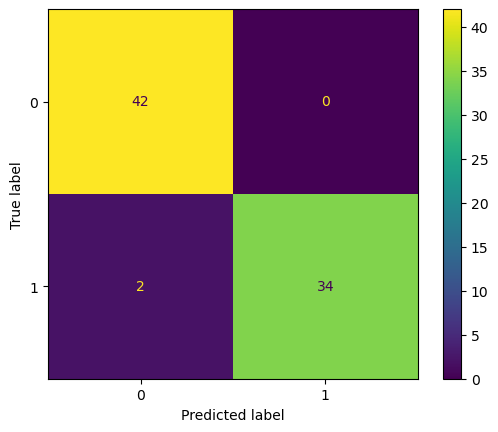

In [61]:
# evaluate on train

model.eval()

num_correct = 0.0
metric_count = 0

y_true = []
y_pred = []

for test_data in train_loader:
    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    with torch.no_grad():
        test_outputs = model(test_images)
        value = torch.eq(test_outputs.argmax(dim=1), test_labels)
        metric_count += len(value)
        num_correct += value.sum().item()
        
        y_true += test_labels.tolist()
        y_pred += test_outputs.argmax(dim=1).tolist()
        
        
        
metric = num_correct / metric_count

print(f"Train accuracy: {metric:.4f} ")

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()

print(classification_report(y_true, y_pred, target_names=['Adenocarcinoma', 'Squamous cell carcinoma']))
        




In [82]:
# save weights and model

torch.save(model.state_dict(), '3dcnn_array_fused.pth')